In [129]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import mlflow
import os

In [130]:
data = pd.read_csv('../Data/breast-cancer.csv')
data.head(20).to_html('assets/datasample.html')

In [131]:
X = data.drop(['id', 'diagnosis'],axis=1)
y = pd.Series(LabelEncoder().fit_transform(data['diagnosis']))

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=400)

In [133]:
Models = {}

Models['Log_reg'] = Pipeline(steps=[
                            ('scaler', MinMaxScaler()),
                            ('model', LogisticRegression(random_state=400))])

Models['SVC_linear'] = Pipeline(steps=[
                            ('scaler', MinMaxScaler()),
                            ('model', LinearSVC(random_state=400,C=2))])

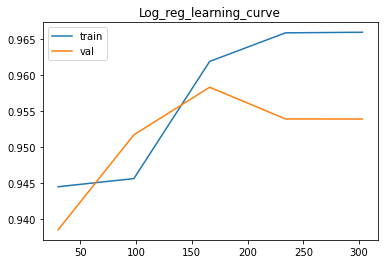

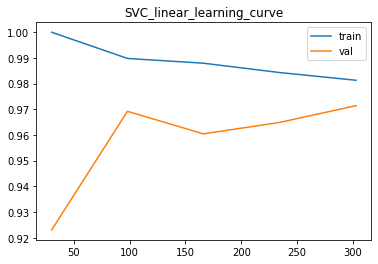

In [135]:
mlflow.set_experiment('Cancer Pred')

for key,model in Models.items():
    with mlflow.start_run(run_name=key):

        cv = cross_validate(model, X_train, y_train ,cv=3,
                            scoring=['accuracy'],
                            return_train_score=True, n_jobs=-1)

        cv_result = pd.DataFrame(cv).to_html('assets/cv_result.html')
        
        N, train,val = learning_curve(model, X_train, y_train, cv=3, random_state=400)
        plt.figure()
        plt.plot(N, train.mean(1), label='train')
        plt.plot(N, val.mean(1), label ='val')
        plt.title(f'{key}_learning_curve')
        plt.legend()
        plt.savefig(f'{key}_learning_curve.png')

        # Fit the model 

        pipeline = model.fit(X_train,y_train)

        pred = pipeline.predict(X_test)

        tp = confusion_matrix(y_test, pred)[0][0]
        fp = confusion_matrix(y_test, pred)[0][1]
        fn = confusion_matrix(y_test, pred)[1][0]
        tn = confusion_matrix(y_test, pred)[1][1]
        
        # Metrics
        
        mlflow.log_metric('Accuracy Train', cv['train_accuracy'].mean())
        mlflow.log_metric('Accuracy Test', cv['test_accuracy'].mean())
        mlflow.log_metric('Nb True positive', tp)
        mlflow.log_metric('Nb Faux positive', fp)
        mlflow.log_metric('Nb Faux negative', fn)
        mlflow.log_metric('Nb True negative', tn)
        
        # Params 

        mlflow.log_params(model.steps[1][1].get_params())

        #Artifact

        mlflow.log_artifact('assets/datasample.html')
        mlflow.log_artifact('assets/cv_result.html')
        mlflow.log_artifact(f'{key}_learning_curve.png')
        os.remove(f'{key}_learning_curve.png')

        #Log Model

        mlflow.sklearn.log_model(pipeline, 'model')